## Olympics Prediction Model

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install tensorflow[and-cuda]

In [ ]:
!pip install dython
!pip install scikit-metrics
!pip install pygraphviz

import os
os._exit(00)

In [ ]:
# Import packages

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-to_re18q because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#Import Data

snowflake.get_connection(connection_name="ME_OLYMPICS_CNX")
data = get_dataframe("ATHLETE_EVENTS")
data
data_bkp = get_dataframe("ATHLETE_EVENTS")
data_bkp

Exception occurred in getting snowflake connection: 'connectionSources'
Reading dataframe from snowflake native connector
Reading dataframe from snowflake native connector


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


#EDA
data['AGE'].value_counts().to_dict()
data.info()
data['AGE'][data['AGE']!='NA'].astype(int).median()
data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()
data['HEIGHT'][data['HEIGHT']!='NA'].astype(int).median()

In [4]:
data.columns = data.columns.str.lower()
#data.info()

In [5]:
data = data.drop(['id', 'name', 'games','event', 'noc', 'weight'], axis=1)

data['WEIGHT'] = data['WEIGHT'].replace('NA',str(float(data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()))).astype(float)

data['WEIGHT'].value_counts().to_dict()

data.info()

In [6]:
data['age'] = data['age'].replace('NA',str(int(data['age'][data['age']!='NA'].astype(int).median()))).astype(int)
data['height'] = data['height'].replace('NA',str(int(data['height'][data['height']!='NA'].astype(int).median()))).astype(int)

# CREATING LABELS

In [8]:
data['medal'].value_counts()
data['medals']= data['medal'].map({'Gold': 3, 'Silver': 2 , 'Bronze': 1, 'NA' : 0}) 

data['medals'].value_counts()
data['medal'] = data['medal'].apply(lambda x: 1 if str(x) != 'nan' else 0)

In [9]:
# taking a copy of data at this stage
data_bkp_step2 = data.copy(deep= True)
data = data.drop(['medal'], axis=1)

In [10]:
#Dropping columns as necessary,
#weight correlated with height, hence dropping
data.info()
# data_bkp_step2.info()
# data['age'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   sex     271116 non-null  object
 1   age     271116 non-null  int64 
 2   height  271116 non-null  int64 
 3   team    271116 non-null  object
 4   year    271116 non-null  int16 
 5   season  271116 non-null  object
 6   city    271116 non-null  object
 7   sport   271116 non-null  object
 8   medals  271116 non-null  int64 
dtypes: int16(1), int64(3), object(5)
memory usage: 17.1+ MB


# Cleaning data

In [11]:
# converting datatypes
data = data.astype({'age': int, 'height': int})
print(data.dtypes)

sex       object
age        int64
height     int64
team      object
year       int16
season    object
city      object
sport     object
medals     int64
dtype: object


In [12]:
#Checks
data.isna().mean()
print("Total missing values:", data.isna().sum().sum())

Total missing values: 0


In [13]:
data_bkp_step3= data.copy(deep= True)

In [ ]:
# data_bkp_step3.info()
#data['year'].value_counts().sort_values()
# data['season'].value_counts()

In [14]:
data = data[data['season'] == 'Summer'].reset_index()
data = data[data['year'] > 1960].reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158148 entries, 0 to 158147
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   level_0  158148 non-null  int64 
 1   index    158148 non-null  int64 
 2   sex      158148 non-null  object
 3   age      158148 non-null  int64 
 4   height   158148 non-null  int64 
 5   team     158148 non-null  object
 6   year     158148 non-null  int16 
 7   season   158148 non-null  object
 8   city     158148 non-null  object
 9   sport    158148 non-null  object
 10  medals   158148 non-null  int64 
dtypes: int16(1), int64(5), object(5)
memory usage: 12.4+ MB


In [ ]:
#data['season'].value_counts()
#data['year'].value_counts()

In [15]:
data = data.drop([ 'level_0', 'index'], axis=1)
data = data[data['sport'].map(data['sport'].value_counts()) > 3000]
data = data[data['team'].map(data['team'].value_counts()) > 2]

# Checks
data['sport'].value_counts()
data['medals'].value_counts()
data['year'].value_counts()

# Over all filters:
Season: Summer only
Year: >1960 only
SPorts that had more than 1500 values
Team: that had more than 2 values
    removed rep. columns like noc, event, etc.
    removing weight column as it is highly correlated to height column

In [16]:
#copy data
data_bkp_step4= data.copy(deep= True)

# Encoding Data

In [ ]:
# data['medals'].value_counts()

In [17]:
{column: len(data[column].unique()) for column in data.select_dtypes('object').columns}
data = data.drop(['season'], axis=1)

In [18]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

#df = binary_encode(
    f_data2,
    columns=['sex', 'season'],
    positive_values=['M', 'Summer']
)



In [19]:
df1 = onehot_encode(
    data,
    columns=['sex','team', 'city', 'sport'],
    prefixes=['sex','t', 'c', 's']
)
print("Remaining non-numeric columns:", len(df1.select_dtypes('object').columns))

In [ ]:
#df1['season'].info()
#df1 = df1.drop(['season'], axis=1)

In [21]:
df1.reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136578 entries, 0 to 158147
Columns: 308 entries, age to s_Wrestling
dtypes: bool(304), int16(1), int64(3)
memory usage: 44.0 MB


# Visualizing Correlations

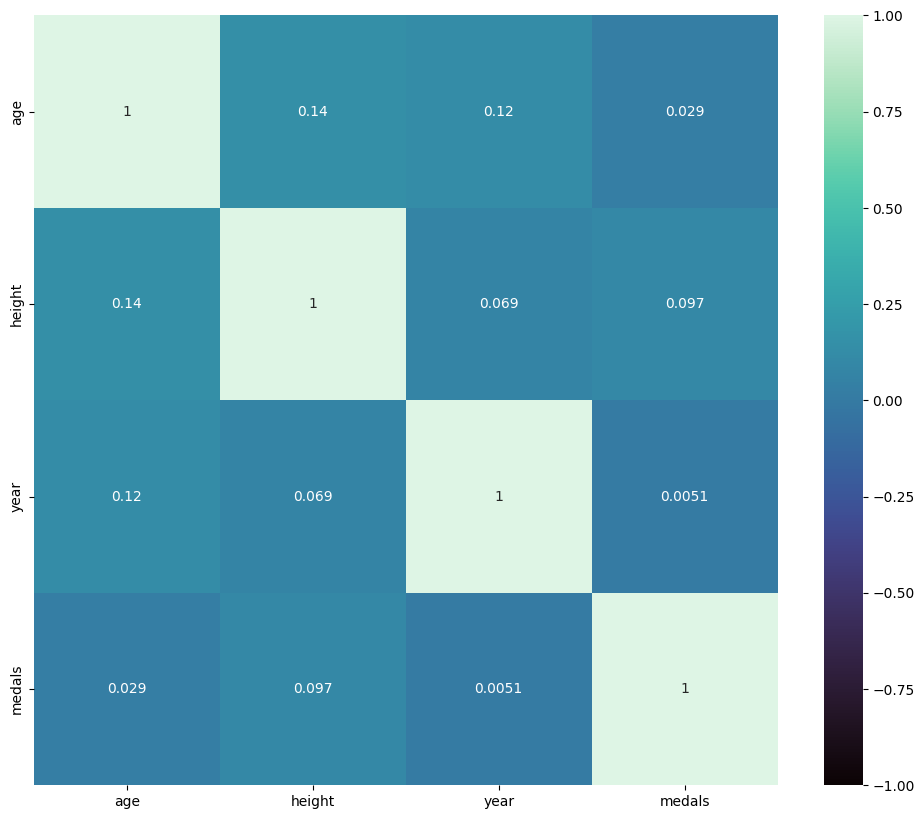

In [22]:
corr = df1.loc[:, :'medals'].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [ ]:
#grouped_data = data.groupby('team', 'sport')['medals'].sum()

# Splitting/Scaling

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136578 entries, 0 to 158147
Columns: 308 entries, age to s_Wrestling
dtypes: bool(304), int16(1), int64(3)
memory usage: 44.0 MB


In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,  classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
#plot_confusion_matrix not working under skleearn metrics

In [25]:
y = df1['medals'].copy()
X = df1.drop('medals', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# XGBoost Model v1

In [ ]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)

xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

# XGBoost Model V2

In [ ]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)

xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

# XGBoost Model v3

In [ ]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

In [ ]:
## ---------- Plot Feature Importance ----------
## plotting feature importance of best xgboost model (v3)

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

In [ ]:
## ---------- Plot Model Tree ----------
## plotting model tree of best xgboost model (v3)

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 28,12
xgb.plot_tree(xgb_clf)
plt.show()

# Old Section: DO NOT RUN

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

In [ ]:
X.shape

In [ ]:
print("Class Distribution (Positive to Negative): {:.1f}% / {:.1f}%".format(y_train.mean() * 100, (1 - y_train.mean()) * 100))

In [ ]:
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=50,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

In [ ]:
y_train

# Results : OLD Section: DO NOT RUN

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_true = np.array(y_test)
y_pred = np.squeeze(np.array(model.predict(X_test) >= 0.5, dtype=int))

In [ ]:
print("Classification Report:\n\n", classification_report(y_true, y_pred))

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
y_pred